In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Connexion à google drive pour sauvegarder les poids du réseau et des enregistrements de parties

In [0]:
import gym
import matplotlib.pyplot as plt
from random import sample, uniform
import random
from torch import nn
import torch
import numpy as np
import torch.optim as optim
import copy
from gym.wrappers import Monitor
import collections
from google.colab import files
from PIL import Image
from IPython.display import HTML, display
from torchvision import transforms
from matplotlib.pyplot import imshow
# Debugging execution time
import datetime

display_progress = True

%matplotlib inline
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Reinforcement/'
base_dir_save = root_dir + 'Reinforcement_save/'



In [0]:
def progress(value, max=100):
  '''
  Affiche une barre de chargement (pour l'entrainement)
  '''
  return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

# Deep Q-network sur CartPole
## Question 1

In [0]:
env = gym.make('CartPole-v1')
all_rewards = []
experience_nb = 0

experience_replay = []
for game in range(100):
    observation = env.reset()
    done = False
    rewards = []
    while not done:
        # env.render()
        previous_obs = observation
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        rewards.append(reward)
        if len(experience_replay) >= 100000:
            experience_replay[experience_nb%100000] = (previous_obs,action,observation,reward,done)
            experience_nb += 1
        else:
            experience_replay.append((previous_obs,action,observation,reward,done))
    all_rewards.append(sum(rewards))
env.close()



## Question 2

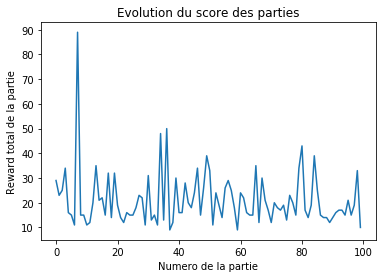

In [0]:
plt.plot(all_rewards)
plt.title("Evolution du score des parties")
plt.xlabel("Numero de la partie")
plt.ylabel("Reward total de la partie")
plt.show()

## Question 3 et 4

In [0]:
def minibatch_from_memory(experiences, number=10):
  '''
  Fonction que retourne un batch de taille number tiré aléatoirement sans remise de experiences
  '''
  batch = sample(experiences, number)
  batch_pobs, batch_action, batch_obs, batch_reward, batch_done = [], [], [], [], []
  for pobs, action, obs, reward, done in batch:
    batch_pobs.append(pobs)
    batch_action.append(action)
    batch_obs.append(obs)
    batch_reward.append(reward)
    batch_done.append(done)
  return batch_pobs, batch_action, batch_obs, batch_reward, batch_done

print(len(experience_replay))
print(minibatch_from_memory(experience_replay))

2114
([array([-0.24785213, -0.57621765,  0.2079089 ,  0.89523913]), array([ 0.00503733, -0.59980214,  0.01340624,  0.83016622]), array([-0.03576882, -0.1495178 ,  0.03063991,  0.30422309]), array([-0.03652466, -0.37305561,  0.03337241,  0.58060334]), array([-0.29449232, -1.37014282,  0.16682343,  1.72800758]), array([ 0.14433222,  0.78932122, -0.10742049, -1.18883458]), array([-0.01984291, -0.01345007,  0.01616921,  0.01097058]), array([-0.04326453,  0.36003909,  0.20716458,  0.15551777]), array([ 0.05391423,  0.16675914, -0.020747  , -0.31003001]), array([ 0.02102815, -0.15363443,  0.0093549 ,  0.32573918])], [1, 1, 1, 1, 0, 1, 1, 0, 0, 0], [array([-0.25937648, -0.38442875,  0.22581368,  0.67443694]), array([-0.00695871, -0.40486598,  0.03000956,  0.54172957]), array([-0.03875918,  0.04515441,  0.03672437,  0.02135857]), array([-0.04398577, -0.17841679,  0.04498447,  0.29861735]), array([-0.32189518, -1.56673276,  0.20138359,  2.06761757]), array([ 0.16011864,  0.98565894, -0.13119719

## Question 5

In [0]:
input_size = 4
hidden_sizes = [30, 30]
output_size = 2

# Build a feed-forward network
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size))

use_cuda = True
device = "cpu"
if use_cuda and torch.cuda.is_available():
    model.cuda()
    device = "cuda"

device = torch.device(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
input = torch.tensor(np.array([[0.03705939, -0.02931123, 0.01712413, 0.01089857]]*2)).to(device)
print(input)
model.double()
y_pred = model(input).tolist()
y_pred

tensor([[ 0.0371, -0.0293,  0.0171,  0.0109],
        [ 0.0371, -0.0293,  0.0171,  0.0109]], device='cuda:0',
       dtype=torch.float64)


[[-0.11463228969499081, 0.1694792188468146],
 [-0.11463228969499081, 0.1694792188468146]]

model est un réseau de neurones prennant en entrée 4 valeurs représentant un état
et retourne en sortie la prédiction de la QValeur pour chaque action possible

## Question 6

In [0]:
#Exploration

def exploration_greedy(out, epsilon):
  if len(out) == 1:
    out = out[0]
  if uniform(0,1) > epsilon:
      return int(out.max(0)[1])
  else:
      return random.randint(0, len(out)-1)

def exploration_boltzmann(out, tau):
    out_np = np.array(out)
    proba = np.exp(out_np/tau)
    proba = proba/sum(proba)
    return np.random.choice(len(out), 1, p=proba)[0]

## Question *7*

In [0]:
def train(optimizer, model, target, minibatch, gamma):
  '''
  Fonction qui entraine un model selon un minibatch.
  Elle sera appellée itérativement par la fonction "train_on_game"
  '''
  errors = []
  optimizer.zero_grad()
  prev, act, cur, rew, done = minibatch
  prev = torch.tensor(prev).to(device)
  act  = torch.tensor(act).to(device)
  cur  = torch.tensor(cur).to(device)
  rew  = torch.tensor(rew).to(device)
  # Boolean to int
  done = torch.tensor(done).long().to(device)

  # model(prev) return batch of qvalues
  # gather() return the qvalue of action 
  # squeeze to 1D
  prevQ     = model(prev).gather(1, act.unsqueeze(1)).squeeze()
  curQ      = target(cur)
  
  # get only the best value of the nextQ
  max_cur_Q = torch.max(curQ, 1)[0]

  expected_prev_Q = rew + (1 - done) * gamma * max_cur_Q

  # detach to not update weight of target network 
  error = (prevQ - expected_prev_Q.detach())**2
  error.sum().backward()
  optimizer.step()
  return error.sum()

train(optimizer, model, copy.deepcopy(model), minibatch_from_memory(experience_replay, 10), 0.999)

tensor(15.4309, device='cuda:0', dtype=torch.float64, grad_fn=<SumBackward0>)

## Question 8

In [0]:
def graduate_update_target(target, model, alpha):
  '''
  Mise à jour graduelle du réseau target vers le réseau model
  '''
  for layer_index in range(target):
    for neuron_index in range(target[layer_index].weight[layer_index]):
      target.weight[layer_index][neuron_index] = (1 - alpha)*target.weight[layer_index][neuron_index] + alpha * model.weight[layer_index][neuron_index]

#graduate_update_target(target, model, 0.005)

In [0]:
def save_model(model):
  '''
  Sauvegarde model dans un fichier
  '''
  torch.save(model.state_dict(), base_dir + 'model' + datetime.datetime.now().strftime("%m%d%Y_%H%M%S") + '.data')

In [0]:
def evaluate_model(env, model, nb_games, render=False, max_episode_by_game=200):
  '''
  Joue nb_games avec model et calcule le score moyen
  '''
  for game in range(nb_games):
    observation = env.reset()
    done = False
    rewards = []
    while not done:
        # env.render()
        previous_obs = observation
        out = model(torch.from_numpy(previous_obs))
        action = out.max(0)[1]
        observation, reward, done, info = env.step(int(action))
        rewards.append(reward)
        # Arrête la partie après max_episode_by_game actions pour éviter des parties trop longues qui tireraient la moyenne vers le haut
        if len(rewards) > max_episode_by_game:
          break
    all_rewards.append(sum(rewards))
  return sum(all_rewards)/len(all_rewards)

In [0]:
def train_on_game(env, model, optimizer, device, exploration_function, training_function, 
                    max_episode_by_game=200, max_steps=100000, render=False, 
                    experience_replay_size=100000, batchs_size=10, epsilon=0.5,
                    gamma=0.999, target_update_steps=1000, debugging=False,
                    replay_start_size=50000, save_frequency=10, gif_creation_frequency=None):
  ''' 
  Entraine le réseau model sur le jeu env via la fonction training_function et exploration_function
  '''
  start_training_time = datetime.datetime.now()
  epsilon_annealing = epsilon/max_steps
  experience_replay = []
  all_rewards = []
  all_errors = []
  step = 0
  experience_nb = 0
  episode_counter = 0

  copy_target_time = 0
  sample_minibatch_time = 0
  train_model_time = 0

  # Barre de progression
  if display_progress:
    progress_bar = display(progress(0, 100), display_id=True)
  
  while step < max_steps:
    observation = env.reset()
    done = False
    rewards = []
    gif = []
    while not done:
        if step % target_update_steps == 0:
          start_copy_target_time = datetime.datetime.now()
          if debugging:
            print("Update target")
          # Met à jour target par une copie intégrale du réseau model (pas de mise à jour graduelle)
          target = copy.deepcopy(model)
          copy_target_time += (datetime.datetime.now() - start_copy_target_time).total_seconds()
        step += 1
        if render:
            env.render()

        previous_obs = observation

        # EXPLORATION GREEDY
        if uniform(0,1) > epsilon:
            out = model(torch.from_numpy(previous_obs).to(device).unsqueeze(0))
            action = int(out[0].max(0)[1])
        else:
            action = random.randint(0, env.action_space.n-1)
        
        # Joue l'action choisie
        observation, reward, done, info = env.step(action)
        rewards.append(reward)

        epsilon = max(epsilon - epsilon_annealing,0)
        
        # EXPERIENCE REPLAY
        if len(experience_replay) >= experience_replay_size:
            experience_replay[experience_nb%experience_replay_size] = (previous_obs,action,observation,reward,done)
            experience_nb += 1
        else:
            experience_replay.append((previous_obs,action,observation,reward,done))
        
        # TRAINING
        if len(experience_replay) >= replay_start_size:
            start_minibatch_time = datetime.datetime.now()
            minibatch = minibatch_from_memory(experience_replay, batchs_size)
            sample_minibatch_time += (datetime.datetime.now() - start_minibatch_time).total_seconds()


            start_train_model_time = datetime.datetime.now()
            all_errors.append(training_function(optimizer, model, target, minibatch, gamma))
            train_model_time += (datetime.datetime.now() - start_train_model_time).total_seconds()

        if len(rewards) > max_episode_by_game:
          break
    
    episode_counter += 1

    # On sauvegarde model
    if step >= replay_start_size and episode_counter % save_frequency == 0:
      save_model(model)
      if debugging:
        print("Saved")

    # On sauvegarde un gif de la partie, pour visualiser les comportements
    if step >= replay_start_size and gif_creation_frequency is not None and episode_counter % gif_creation_frequency == 0:
      env.save_gif()

    all_rewards.append(sum(rewards))

    if display_progress:
      progress_bar.update(progress(int(step/max_steps*100), 100))

    if debugging and step >= replay_start_size:
        print("r :", all_rewards[-1],  'e :', epsilon)
        print("Step of game :", len(rewards))
        
  save_model(model)

  if debugging:
    total_training_time = (datetime.datetime.now() - start_training_time).total_seconds()
    print("Total time :", start_training_time, datetime.datetime.now(), datetime.datetime.now() - start_training_time,  total_training_time)
    print("copy_target_time :", copy_target_time, copy_target_time/total_training_time)
    print("sample_minibatch_time :", sample_minibatch_time, sample_minibatch_time/total_training_time)
    print("train_model_time :", train_model_time, train_model_time/total_training_time)
        
  return model, all_rewards, all_errors

On testes différents modèles de réseaux de neurones pour comparer leurs performances 

In [0]:
averages = {}

input_size = 4
output_size = 2

models = [nn.Sequential(nn.Linear(input_size, 30),
                      nn.ReLU(),
                      nn.Linear(30, 30),
                      nn.ReLU(),
                      nn.Linear(30, output_size)),
          nn.Sequential(nn.Linear(input_size, 20),
                      nn.ReLU(),
                      nn.Linear(20, 20),
                      nn.ReLU(),
                      nn.Linear(20, output_size)),
          nn.Sequential(nn.Linear(input_size, 10),
                      nn.ReLU(),
                      nn.Linear(10, 10),
                      nn.ReLU(),
                      nn.Linear(10, output_size)),
          nn.Sequential(nn.Linear(input_size, 5),
                      nn.ReLU(),
                      nn.Linear(5, 5),
                      nn.ReLU(),
                      nn.Linear(5, output_size)),
          nn.Sequential(nn.Linear(input_size, 4),
                      nn.ReLU(),
                      nn.Linear(4, 4),
                      nn.ReLU(),
                      nn.Linear(4, output_size)),
          nn.Sequential(nn.Linear(input_size, 100),
                      nn.ReLU(),
                      nn.Linear(100, 100),
                      nn.ReLU(),
                      nn.Linear(100, output_size)),
          ]

hyperparameters = {
    '30x30'  : models[0], 
    '20x20'  : models[1], 
    '10x10'  : models[2], 
    '5x5'    : models[3],
    '4x4'    : models[4], 
    '100x100': models[5], 
}


average_size = 50
max_steps = 50000

use_cuda = False

for hyperparameter in hyperparameters:
  model = hyperparameters[hyperparameter]
  device = "cpu"
  if use_cuda and torch.cuda.is_available():
      model.cuda()
      device = "cuda"
      
  model.double()

  device = torch.device(device)
  optimizer = optim.RMSprop(model.parameters(), lr=0.001)

  model, all_rewards, all_errors = train_on_game(
      env=env, 
      model=model, 
      optimizer=optimizer, 
      device=device, 
      exploration_function=exploration_greedy, 
      training_function=train,
      max_steps=max_steps,
      replay_start_size=32,
      batchs_size=32,
      save_frequency=200,
      debugging=False)

  average = []
  for i in range(len(all_rewards)//average_size):
    average.append(sum(all_rewards[i*average_size:(i+1)*average_size])/len(all_rewards[i*average_size:(i+1)*average_size]))
  averages[hyperparameter] = average

print(averages)

{'30x30': [18.36, 17.32, 19.08, 41.34, 108.74, 145.88, 130.42, 117.3, 143.36, 167.68], '20x20': [12.56, 14.8, 14.46, 16.88, 35.12, 77.32, 90.26, 85.96, 72.88, 67.6, 94.98, 84.82, 98.3, 93.44, 99.4], '10x10': [14.02, 13.22, 12.56, 12.94, 15.98, 32.54, 90.8, 136.34, 173.16, 185.76, 159.14, 133.14], '5x5': [14.92, 15.56, 28.68, 49.22, 65.3, 79.8, 83.96, 143.32, 172.06, 193.94], '4x4': [12.88, 12.68, 12.74, 14.34, 16.76, 24.26, 59.94, 70.4, 62.32, 65.96, 57.78, 72.32, 71.88, 70.82, 64.24, 85.0, 103.08, 113.36], '100x100': [22.12, 23.78, 34.36, 73.04, 104.02, 114.66, 92.58, 113.68, 114.46, 112.34, 108.52]}


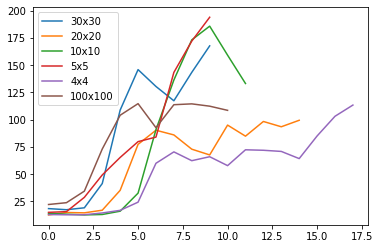

In [0]:
# Affiche l'évolution de l'apprentissage de chaque model 
for hyperparameter, average in averages.items():
  plt.plot(average)
plt.legend(averages.keys())
plt.show()

In [0]:
# Affiche les performances (score moyen) sur 1000 parties
for hyperparameter in hyperparameters:
  model = hyperparameters[hyperparameter]
  print("Average score ", hyperparameter, "on 1000 games : ", evaluate_model(env, model, 1000))

Average score  30x30 on 1000 games :  133.41825095057035
Average score  20x20 on 1000 games :  119.10046547711404
Average score  10x10 on 1000 games :  140.28088317495806
Average score  5x5 on 1000 games :  152.23241590214067
Average score  4x4 on 1000 games :  145.04392255288633
Average score  100x100 on 1000 games :  153.52690787473395


# Environnement plus difficile : Breakout Atari
## Question 1

In [0]:
def preprocess_frames(frames):
  '''
  Prend en paramètre une liste d'obervations et les redimensionne, les met en noir et blanc et les assemble
  '''
  final_frame = torch.tensor((), dtype=torch.double)
  transform = transforms.Compose([transforms.ToPILImage(),transforms.Resize((84,84)), transforms.Grayscale(1), transforms.ToTensor()])
  for f in frames:
    frame = transform(f)[0]
    final_frame = torch.cat((final_frame, frame.double()), 0).double()
  return np.array(final_frame.view(1, 336, 84))

## Question 5

In [0]:
class BreakoutEnv:
  '''
  Class surchargeant breakout pour permettre de pre-process les observations
  '''
  def __init__(self, frame_fusion_nb):
    self.env = gym.make('BreakoutNoFrameskip-v4')
    self.frame_fusion_nb = frame_fusion_nb
    self.action_space = self.env.action_space
    self.gif = []
    
  def reset(self):
    observation = self.env.reset()
    self.last_observations = [observation] * self.frame_fusion_nb
    self.last_observations = preprocess_frames(self.last_observations)
    self.gif = []
    return self.last_observations

  def save_gif(self):
    frames = []
    for f in self.gif:
      frames.append(Image.fromarray(f))
    frames[0].save(base_dir+'breakout' + datetime.datetime.now().strftime("%m%d%Y_%H%M%S") + '.gif', format='GIF', append_images=frames[1:], save_all=True, duration=20, loop=0)


  def step(self, action):
    observations = []
    rewards = []
    lost_life = False
    for i in range(self.frame_fusion_nb):
      observation, reward, done, info = self.env.step(action)
      self.gif.append(observation)
      observations.append(observation)
      rewards.append(reward)

    # Pour améliorer l'apprentissage, on considère que l'agent n'a qu'une vie
    lost_life = self.env.ale.lives() != 5
    done = done if lost_life == False else True
    return preprocess_frames(observations), sum(rewards), done, info

  def render(self):
    self.env.render()

## Question 3

In [0]:
# Nombre de frame skip et traitées à la fois
frame_fusion_nb = 4

env = BreakoutEnv(frame_fusion_nb)

input_size = 336*84
output_size = env.action_space.n

model = nn.Sequential(nn.Conv2d(1, 32, kernel_size=8, stride=4),
                      nn.ReLU(),
                      nn.Conv2d(32, 64, kernel_size=4, stride=2),
                      nn.ReLU(),
                      nn.Conv2d(64, 64, kernel_size=4, stride=2),
                      nn.ReLU(),
                      nn.Flatten(),
                      nn.Linear(3648, 128),
                      nn.ReLU(),
                      nn.Linear(128, 256),
                      nn.ReLU(),
                      nn.Linear(256, 4))

In [0]:
# Décommenter pour charger les fichiers via un input html
#from google.colab import files
#!rm model*
#uploaded = files.upload()

In [0]:
# Décommenter pour charger le modèle depuis le drive précédemment lié via la première cellule
model.load_state_dict(torch.load(base_dir + "model12292019_114851.data"), strict=False)
model.eval()

Sequential(
  (0): Conv2d(1, 32, kernel_size=(8, 8), stride=(4, 4))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (3): ReLU()
  (4): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2))
  (5): ReLU()
  (6): Flatten()
  (7): Linear(in_features=3648, out_features=128, bias=True)
  (8): ReLU()
  (9): Linear(in_features=128, out_features=256, bias=True)
  (10): ReLU()
  (11): Linear(in_features=256, out_features=4, bias=True)
)

Entraine le modèle sur le jeu Breakout

In [0]:
max_steps = 6000

device = "cpu"
use_cuda = True
if use_cuda and torch.cuda.is_available():
    model.cuda()
    device = "cuda"

device = torch.device(device)
optimizer = optim.RMSprop(model.parameters(), lr=0.00025)
model.double()

model, all_rewards, all_errors = train_on_game(
    env=env, 
    model=model, 
    optimizer=optimizer, 
    device=device, 
    exploration_function=exploration_greedy, 
    training_function=train,
    max_steps=max_steps,
    max_episode_by_game = 1000,
    target_update_steps = 10000,
    epsilon=0.3,
    gamma = 0.99,
    batchs_size=32,
    replay_start_size=5000,
    experience_replay_size=10000,
    save_frequency=100,
    gif_creation_frequency=100,
    debugging=True)




## Implémentation du prioritized experience replay

In [0]:
def minibatch_prioritized(experiences, priorities, number=10):
  '''
  Retourne un batch de taille number issu de l'expérience replay. On utilise
  la prioritized experience replay: la probabilité de tirer chaque expérience
  n'est pas uniforme. Elle est proportionnelle au vecteur priorities.
  '''
  batch_index = np.random.choice(len(experiences), size=number, replace=False, p=priorities / np.sum(priorities))
  batch_pobs, batch_action, batch_obs, batch_reward, batch_done = [], [], [], [], []
  for index in batch_index:
    pobs, action, obs, reward, done = experiences[index]
    batch_pobs.append(pobs)
    batch_action.append(action)
    batch_obs.append(obs)
    batch_reward.append(reward)
    batch_done.append(done)
  return batch_index, batch_pobs, batch_action, batch_obs, batch_reward, batch_done


In [0]:
def best_train(optimizer, model, target, minibatch, priorities, gamma):
  '''
  Copie de la fonction train mais avec en plus la gestion des priorités dans les expériences
  '''
  errors = []
  optimizer.zero_grad()
  indices, prev, act, cur, rew, done = minibatch
  prev = torch.tensor(prev).to(device)
  act  = torch.tensor(act).to(device)
  cur  = torch.tensor(cur).to(device)
  rew  = torch.tensor(rew).to(device)
  # Boolean to int
  done = torch.tensor(done).long().to(device)

  # model(prev) return batch of qvalues
  # gather() return the qvalue of action 
  # squeeze to 1D
  prevQ     = model(prev).gather(1, act.unsqueeze(1)).squeeze()
  curQ      = target(cur)

  
  # get only the best value of the nextQ
  max_cur_Q = torch.max(curQ, 1)[0]

  expected_prev_Q = rew + (1 - done) * gamma * max_cur_Q

  # detach to not update weight of target network 
  error = (prevQ - expected_prev_Q.detach())**2
  error.sum().backward()
  optimizer.step()
  
  # If the error is large, this means the experience is surprising, and thus we
  # have new things to learn from it. Therefore, priority will correspond to the
  # error made.
  priorities[indices] = error.detach().cpu().numpy()
  return error.sum()


In [0]:
def best_dqn(env, model, optimizer, device, exploration_function, training_function, 
                    max_episode_by_game=200, max_steps=100000, render=False, 
                    experience_replay_size=100000, batchs_size=10, epsilon=0.5,
                    gamma=0.999, target_update_steps=1000, debugging=False,
                    replay_start_size=50000, save_frequency=10, gif_creation_frequency=None):
  
  '''
  Copie de la fonction train_on_game mais avec le prioritized experience replay
  '''
    
  epsilon_annealing = epsilon/max_steps
  experience_replay = [0]*experience_replay_size
  all_rewards = []
  all_errors = []
  step = 0
  experience_nb = 0
  episode_counter = 0
  max_proba = 100
  list_proba = np.ones(experience_replay_size)
  

  if display_progress:
    progress_bar = display(progress(0, 100), display_id=True)
  
  while step < max_steps:
    observation = env.reset()
    done = False
    rewards = []
    gif = []
    while not done:
        if step % target_update_steps == 0:
          if debugging:
            print("Update target")
          target = copy.deepcopy(model)
        step += 1
        if render:
            env.render()

        previous_obs = observation

        # EXPLORATION VS GREEDY
        if uniform(0,1) > epsilon:
            out = model(torch.from_numpy(previous_obs).to(device).unsqueeze(0))
            action = int(out[0].max(0)[1])
        else:
            action = random.randint(0, env.action_space.n-1)
        
        # action = exploration_function(out, epsilon)
        observation, reward, done, info = env.step(action)
        rewards.append(reward)

        epsilon = max(epsilon - epsilon_annealing,0)
        
        # EXPERIENCE REPLAY
        experience_replay[experience_nb%experience_replay_size] = (previous_obs,action,observation,reward,done)
        
        # A new experience has maximum priority, in order to be studied at least once
        # before being decided as more or less interesting.
        list_proba[experience_nb%experience_replay_size] = max_proba
        experience_nb += 1
        
        # TRAINING
        if step >= replay_start_size:
            all_errors.append(training_function(optimizer, model, target, minibatch_prioritized(experience_replay, list_proba, batchs_size),list_proba, gamma))

        if len(rewards) > max_episode_by_game:
          break
    
    episode_counter += 1
    if step >= replay_start_size and episode_counter % save_frequency == 0:
      save_model(model)
      if debugging:
        print("Saved")

    if step >= replay_start_size and gif_creation_frequency is not None and episode_counter % gif_creation_frequency == 0:
      env.save_gif()

    # print(step)
    all_rewards.append(sum(rewards))

    if display_progress:
      progress_bar.update(progress(int(step/max_steps*100), 100))

    if debugging and step >= replay_start_size:
        print("r :", all_rewards[-1],  'e :', epsilon)
        print("Step of game :", len(rewards))
        
  save_model(model)
        
  return model, all_rewards, all_errors

## Question 4

In [0]:
# Modèle issu de l'article
best_model = nn.Sequential(nn.Conv2d(1, 32, kernel_size=8, stride=4),
                      nn.ReLU(),
                      nn.Conv2d(32, 64, kernel_size=4, stride=2),
                      nn.ReLU(),
                      nn.Conv2d(64, 64, kernel_size=3, stride=1),
                      nn.ReLU(),
                      nn.Flatten(),
                      nn.Linear(17024, 512),
                      nn.ReLU(),
                      nn.Linear(512, 4))

best_model.load_state_dict(torch.load(base_dir + "model01012020_204704.data"), strict=False)
best_model.eval()

Sequential(
  (0): Conv2d(1, 32, kernel_size=(8, 8), stride=(4, 4))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (3): ReLU()
  (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (5): ReLU()
  (6): Flatten()
  (7): Linear(in_features=17024, out_features=512, bias=True)
  (8): ReLU()
  (9): Linear(in_features=512, out_features=4, bias=True)
)

In [0]:
device = "cpu"
use_cuda = True
if use_cuda and torch.cuda.is_available():
    best_model.cuda()
    device = "cuda"

device = torch.device(device)
optimizer = optim.RMSprop(best_model.parameters(), lr=0.0005)
best_model.double()

best_model, all_rewards, all_errors = best_dqn(
    env=env, 
    model=best_model, 
    optimizer=optimizer, 
    device=device, 
    exploration_function=exploration_greedy, 
    training_function=best_train,
    max_steps=200000,
    max_episode_by_game = 100000,
    target_update_steps = 10000,
    epsilon=0.5,
    gamma = 0.99,
    batchs_size=32,
    experience_replay_size=10000,
    replay_start_size = 10000,
    save_frequency=100,
    gif_creation_frequency=100,
    debugging=True)


Update target
Update target
r : 2.0 e : 0.4749524999998359
Step of game : 104
r : 0.0 e : 0.4748874999998355
Step of game : 26
r : 2.0 e : 0.47457749999983345
Step of game : 124
r : 0.0 e : 0.474512499999833
Step of game : 26
r : 0.0 e : 0.4744499999998326
Step of game : 25
r : 1.0 e : 0.4743124999998317
Step of game : 55
r : 0.0 e : 0.47424249999983126
Step of game : 28
r : 0.0 e : 0.47417999999983085
Step of game : 25
r : 2.0 e : 0.47396749999982946
Step of game : 85
r : 0.0 e : 0.47390499999982905
Step of game : 25
r : 0.0 e : 0.4738249999998285
Step of game : 32
r : 2.0 e : 0.47361249999982713
Step of game : 85
r : 3.0 e : 0.47327749999982494
Step of game : 134
r : 0.0 e : 0.4732149999998245
Step of game : 25
r : 0.0 e : 0.4731524999998241
Step of game : 25
r : 0.0 e : 0.4730874999998237
Step of game : 26
r : 2.0 e : 0.47283749999982205
Step of game : 100
r : 0.0 e : 0.47277499999982164
Step of game : 25
r : 0.0 e : 0.47271249999982123
Step of game : 25
r : 1.0 e : 0.47257999999982